In [1]:
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data

,Unnamed: 0,Date,Close,Open,High,Low,PE,Ratio
0,0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.34,17.12
1,1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.34,17.12
2,2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.34,17.12
3,3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.34,17.12
4,4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.34,17.12
...,...,...,...,...,...,...,...,...
15671,15671,2022-02-11,4418.640000,4506.270000,4526.330000,4401.410000,37.56,25.93
15672,15672,2022-02-14,4401.670000,4412.610000,4426.220000,4364.840000,37.56,25.93
15673,15673,2022-02-15,4471.070000,4429.280000,4472.770000,4429.280000,37.56,25.93
15674,15674,2022-02-16,4475.010000,4455.750000,4489.550000,4429.680000,37.56,25.93


In [3]:
rows = [x for x in data.index if data.loc[x]['Open'] == 0]
data = data.drop(rows, axis=0)

In [4]:
test_data = data.loc[ (data['Date']  >= '1980-01-01' )]
test_data

,Unnamed: 0,Date,Close,Open,High,Low,PE,Ratio
5015,5015,1980-01-02,105.760002,107.940002,108.430000,105.290001,8.85,7.39
5016,5016,1980-01-03,105.220001,105.760002,106.080002,103.260002,8.85,7.39
5017,5017,1980-01-04,106.519997,105.220001,107.080002,105.089996,8.85,7.39
5018,5018,1980-01-07,106.809998,106.519997,107.800003,105.800003,8.85,7.39
5019,5019,1980-01-08,108.949997,106.809998,109.290001,106.290001,8.85,7.39
...,...,...,...,...,...,...,...,...
15671,15671,2022-02-11,4418.640000,4506.270000,4526.330000,4401.410000,37.56,25.93
15672,15672,2022-02-14,4401.670000,4412.610000,4426.220000,4364.840000,37.56,25.93
15673,15673,2022-02-15,4471.070000,4429.280000,4472.770000,4429.280000,37.56,25.93
15674,15674,2022-02-16,4475.010000,4455.750000,4489.550000,4429.680000,37.56,25.93


In [5]:
dataset = data[['Close', 'Open', 'High', 'Low']].values
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.00162509, 0.00162237, 0.00161757, 0.00181023],
       [0.00172626, 0.00172337, 0.00171827, 0.00191173],
       [0.00167146, 0.00166866, 0.00166372, 0.00185675],
       ...,
       [0.93139433, 0.92104261, 0.9274403 , 0.92582301],
       [0.93222479, 0.92661253, 0.93096076, 0.9259076 ],
       [0.91225371, 0.92667776, 0.92393453, 0.91409249]])

In [6]:
test_dataset = test_data[['Close', 'Open', 'High', 'Low']].values
test_dataset = scaler.fit_transform(test_dataset)
test_dataset

array([[0.00160482, 0.00206532, 0.00187538, 0.00236032],
       [0.00148989, 0.00160211, 0.0013774 , 0.00192709],
       [0.00176658, 0.00148737, 0.00158931, 0.00231763],
       ...,
       [0.93072234, 0.92027053, 0.92671179, 0.92514421],
       [0.93156093, 0.92589492, 0.9302676 , 0.92522958],
       [0.91139424, 0.92596079, 0.92317081, 0.91330634]])

In [7]:
date = data[['Date']].values
date.shape

(15640, 1)

In [8]:
test_date = test_data[['Date']].values
test_date.shape

(10625, 1)

In [9]:
# training:0: 0 -180：181 当你输入0-180 predict：181
# 1: 1 -181: 182    1-181， predict：182


# test:2. 200-380 predict：x
#         ｜x - actual｜ / actual 


seq_len = 180
input_size = 4
output_size = 4

real_list = []
label_list = []
date_list = []
for i in range(dataset.shape[0] - seq_len - output_size + 1):
    real_list.append(dataset[i: i + seq_len, ])
    label_list.append(dataset[i + seq_len: i + seq_len + output_size, 0])
    date_list.append(date[i + seq_len])
real_list = np.array(real_list)
label_list = np.array(label_list)
date_list = np.array(date_list)
label_list = np.reshape(label_list, (label_list.shape[0], 1, label_list.shape[1]))
print("real_list: " , real_list.shape)
print("label_list: " , label_list.shape)
print("date_list: " , date_list.shape)

real_list:  (15457, 180, 4)
label_list:  (15457, 1, 4)
date_list:  (15457, 1)


In [10]:
seq_len = 180
input_size = 4
output_size = 4

test_real = []
test_label = []
test_date_list = []
for i in range(test_dataset.shape[0] - seq_len - output_size + 1):
    test_real.append(test_dataset[i: i + seq_len, ])
    test_label.append(test_dataset[i + seq_len: i + seq_len + output_size, 0])
    test_date_list.append(test_date[i + seq_len])
test_real = np.array(test_real)
test_label = np.array(test_label)
test_date_list = np.array(test_date_list)
test_label = np.reshape(test_label, (test_label.shape[0], 1, test_label.shape[1]))
print("test_real_list: " , test_real.shape)
print("test_label_list: " , test_label.shape)
print("test_date_list: " , test_date_list.shape)

test_real_list:  (10442, 180, 4)
test_label_list:  (10442, 1, 4)
test_date_list:  (10442, 1)


In [11]:
real_train_list = []
label_train_list = []
real_test_list = []
label_test_list = []
date_train_list = []
date_test_list = []

"""
80% 用于训练
"""
for i in range(real_list.shape[0]):
    if i % real_list.shape[0] <= real_list.shape[0] * 0.8:
        real_train_list.append(real_list[i,])
        label_train_list.append(label_list[i,])
        date_train_list.append(date_list[i,])
    else:
        real_test_list.append(real_list[i,])
        label_test_list.append(label_list[i,])
        date_test_list.append(date_list[i,])
real_train_list = np.array(real_train_list)
label_train_list = np.array(label_train_list)
real_test_list = np.array(real_test_list)
label_test_list = np.array(label_test_list)
date_train_list = np.array(date_train_list)
date_test_list = np.array(date_test_list)
print("real_train_list: " , real_train_list.shape)
print("label_train_list: " , label_train_list.shape)
print("real_test_list: " , real_test_list.shape)
print("label_test_list: " , label_test_list.shape)
print("date_train_list: " , date_train_list.shape)
print("date_test_list: " , date_test_list.shape)

real_train_list:  (12366, 180, 4)
label_train_list:  (12366, 1, 4)
real_test_list:  (3091, 180, 4)
label_test_list:  (3091, 1, 4)
date_train_list:  (12366, 1)
date_test_list:  (3091, 1)


In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
#         print(x.shape)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        res, hidden = self.rnn(x, hidden)
        res = self.linear(res)
        return res[:, -1, :], hidden
        
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

In [13]:
hidden_size = 16
num_layers = 1
learning_rate = 0.001
num_epochs = 100

In [14]:
model = RNN(input_size, output_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
loss_arr = []

for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(real_train_list).float())
    labels = Variable(torch.from_numpy(label_train_list).float())
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

    # Perform forward pass
    output, hidden = model(inputs)   
    
    # Compute loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_arr.append(loss.item())
       
    # Backward pass
    loss.backward(retain_graph=True)
    
    if (epoch % 10 == 0 or epoch == num_epochs - 1):
        print("[%d/%d] Loss: %.4f" % (epoch, num_epochs, loss.item()))
    
    # Update parameters
    optimizer.step()                                

[0/100] Loss: 0.0183
[10/100] Loss: 0.0104
[20/100] Loss: 0.0083
[30/100] Loss: 0.0070
[40/100] Loss: 0.0049
[50/100] Loss: 0.0022
[60/100] Loss: 0.0010
[70/100] Loss: 0.0003
[80/100] Loss: 0.0001
[90/100] Loss: 0.0000
[99/100] Loss: 0.0000


In [15]:
output, hidden = model(Variable(torch.from_numpy(test_real).float()))
output

tensor([[0.0062, 0.0064, 0.0077, 0.0046],
        [0.0063, 0.0065, 0.0078, 0.0048],
        [0.0065, 0.0066, 0.0079, 0.0050],
        ...,
        [0.5578, 0.5572, 0.5980, 0.5429],
        [0.5566, 0.5590, 0.5974, 0.5416],
        [0.5538, 0.5588, 0.5950, 0.5389]], grad_fn=<SliceBackward0>)

In [16]:
prediction = scaler.inverse_transform(output.detach().numpy())
prediction

array([[ 127.170395,  128.42374 ,  135.7294  ,  115.868744],
       [ 127.821495,  128.94753 ,  136.47943 ,  116.79189 ],
       [ 128.64902 ,  129.47034 ,  137.04367 ,  117.425964],
       ...,
       [2718.895   , 2720.7056  , 2921.3818  , 2638.0479  ],
       [2713.3132  , 2729.0322  , 2918.8699  , 2632.0525  ],
       [2699.9443  , 2727.9038  , 2907.5525  , 2619.27    ]],
      dtype=float32)

In [17]:
def calculate_prediction_error(predicted, actual):
    return abs(predicted - actual)/actual

In [18]:
actual = np.concatenate( (test_label[:, :, 0], test_label[:, :, 1], test_label[:, :, 2], test_label[:, :, 3]), axis = 1)
actual = scaler.inverse_transform(actual)
actual

array([[ 128.869995  ,  128.45106117,  130.74671332,  126.32417518],
       [ 128.399994  ,  129.30250546,  131.90177397,  125.35676108],
       [ 129.25      ,  130.45444535,  130.92749933,  126.29425619],
       ...,
       [4504.08      , 4425.95052648, 4421.99018921, 4455.41804922],
       [4418.64      , 4408.95181177, 4491.69595251, 4459.34754163],
       [4401.67      , 4478.4692426 , 4495.65331141, 4364.85023039]])

In [19]:
error = calculate_prediction_error(prediction, actual)
error.shape

(10442, 4)

In [32]:
def pearson_correlation_coefficient(vector_x, vector_y):
    x_bar = vector_x.mean(axis=1)
    y_bar = vector_y.mean(axis=1)
    x_demean = vector_x - x_bar[:, np.newaxis]
    y_demean = vector_y - y_bar[:, np.newaxis]
    pearson_numerator = np.dot(np.transpose(x_demean), y_demean)
    pearson_denominator = np.linalg.norm(x_demean) * np.linalg.norm(y_demean)
    
    return pearson_numerator/pearson_denominator

# print(prediction)
# print(np.mean(prediction))
# print(prediction.mean(axis=1))
# print(prediction.shape)
# print(prediction.mean(axis=1).shape)
# mean = prediction.mean(axis=1)
# prediction - mean[:, np.newaxis]
# A = np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
# mean = A.mean(axis=1)

pearson_correlation_coefficient(prediction, actual)
# print(prediction.shape)
# print(actual.shape)

array([[ 0.00996076, -0.00552486, -0.03248336,  0.02804746],
       [-0.01271442,  0.0064027 ,  0.04216841, -0.03585669],
       [-0.03485719,  0.02132812,  0.11403693, -0.10050786],
       [ 0.03761084, -0.02220598, -0.12372197,  0.10831711]])

In [33]:
from numpy import cov
from numpy import std
# calculate covariance matrix
covariance = cov(prediction, actual)
# print(covariance)
print(covariance/(std(prediction) * std(actual)))

MemoryError: Unable to allocate 3.25 GiB for an array with shape (20884, 20884) and data type float64

In [28]:
# """

# validation ｜ 把training dataset 分成 80% 20%，其中20%用来做validation dataset

# """


real_val_list = []
label_val_list = []
real_train_list_new = []
label_train_list_new = []
date_train_list_new = []
date_val_list = []



for i in range(real_train_list.shape[0]):
    if i % real_train_list.shape[0] <= real_train_list.shape[0] * 0.8:
        real_train_list_new.append(real_train_list[i,])
        label_train_list_new.append(label_train_list[i,])
        date_train_list_new.append(date_train_list[i,])
    else:
        real_val_list.append(real_train_list[i,])
        label_val_list.append(label_train_list[i,])
        date_val_list.append(date_train_list[i,])
real_train_list_new = np.array(real_train_list_new)
label_train_list_new = np.array(label_train_list_new)
real_val_list = np.array(real_val_list)
label_val_list = np.array(label_val_list)
date_train_list_new = np.array(date_train_list_new)
date_val_list = np.array(date_val_list)
print("real_train_list_new: " , real_train_list_new.shape)
print("label_train_list_new: " , label_train_list_new.shape)
print("real_val_list: " , real_val_list.shape)
print("label_val_list: " , label_val_list.shape)
print("date_train_list_new: " , date_train_list_new.shape)
print("date_val_list: " , date_val_list.shape)

# """
# real_train_list_new:  (9893, 180, 4)
# 9893:batch size
# 180: seq length
# 4: feature
# """

real_train_list_new:  (9893, 180, 4)
label_train_list_new:  (9893, 1, 4)
real_val_list:  (2473, 180, 4)
label_val_list:  (2473, 1, 4)
date_train_list_new:  (9893, 1)
date_val_list:  (2473, 1)


In [29]:
model_val = RNN(input_size, output_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model_val.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

loss_arr = []
loss_val_arr = []

for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(real_train_list_new).float())
    labels = Variable(torch.from_numpy(label_train_list_new).float())
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

    # Perform forward pass
    output, hidden = model_val(inputs)   
    
    # Compute loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_arr.append(loss.item())
       
    # Backward pass
    loss.backward(retain_graph=True)
       
    #loss for validation
    inputs_val = torch.from_numpy(real_val_list).float()
    labels_val = torch.from_numpy(label_val_list).float()
    output_val, hidden_val = model_val(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_val_arr.append(loss_val.item())
    
    if (epoch % 10 == 0 or epoch == num_epochs - 1):
        print("[%d/%d] Loss: %.4f" % (epoch, num_epochs, loss.item()))
        print("[%d/%d] Loss_Val: %.4f" % (epoch, num_epochs, loss_val.item()))
    
    # Update parameters
    optimizer.step()                                

[0/100] Loss: 0.0152
[0/100] Loss_Val: 0.0632
[10/100] Loss: 0.0046
[10/100] Loss_Val: 0.0442
[20/100] Loss: 0.0032
[20/100] Loss_Val: 0.0284
[30/100] Loss: 0.0027
[30/100] Loss_Val: 0.0265
[40/100] Loss: 0.0020
[40/100] Loss_Val: 0.0223
[50/100] Loss: 0.0014
[50/100] Loss_Val: 0.0157
[60/100] Loss: 0.0008
[60/100] Loss_Val: 0.0100
[70/100] Loss: 0.0003
[70/100] Loss_Val: 0.0043
[80/100] Loss: 0.0001
[80/100] Loss_Val: 0.0013
[90/100] Loss: 0.0001
[90/100] Loss_Val: 0.0006
[99/100] Loss: 0.0000
[99/100] Loss_Val: 0.0005


<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

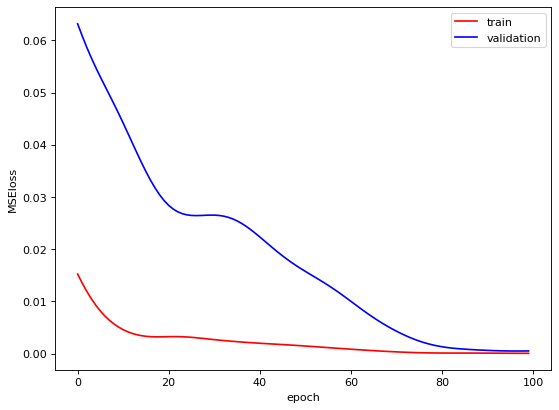

In [30]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_arr), 'r', label = 'train')
plt.plot(np.array(loss_val_arr), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()
plt

In [31]:
output_val, hidden = model_val(Variable(torch.from_numpy(test_real).float()))
output_val

tensor([[4.9457e-04, 4.3759e-03, 3.9904e-03, 2.9065e-03],
        [7.3935e-04, 4.5222e-03, 4.1910e-03, 3.1174e-03],
        [9.7945e-04, 4.8062e-03, 4.4656e-03, 3.3113e-03],
        ...,
        [5.9278e-01, 4.3399e-01, 4.1385e-01, 5.0651e-01],
        [5.9268e-01, 4.3247e-01, 4.1782e-01, 5.0458e-01],
        [5.8895e-01, 4.2976e-01, 4.1820e-01, 5.0200e-01]],
       grad_fn=<SliceBackward0>)

In [32]:
prediction_val = scaler.inverse_transform(output_val.detach().numpy())
prediction_val

array([[ 100.54366 ,  118.814415,  118.41092 ,  107.84918 ],
       [ 101.69372 ,  119.5027  ,  119.35763 ,  108.83754 ],
       [ 102.82178 ,  120.839325,  120.65333 ,  109.74623 ],
       ...,
       [2883.312   , 2140.706   , 2052.5488  , 2467.6235  ],
       [2882.8113  , 2133.564   , 2071.2693  , 2458.5935  ],
       [2865.3198  , 2120.785   , 2073.08    , 2446.511   ]],
      dtype=float32)

<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

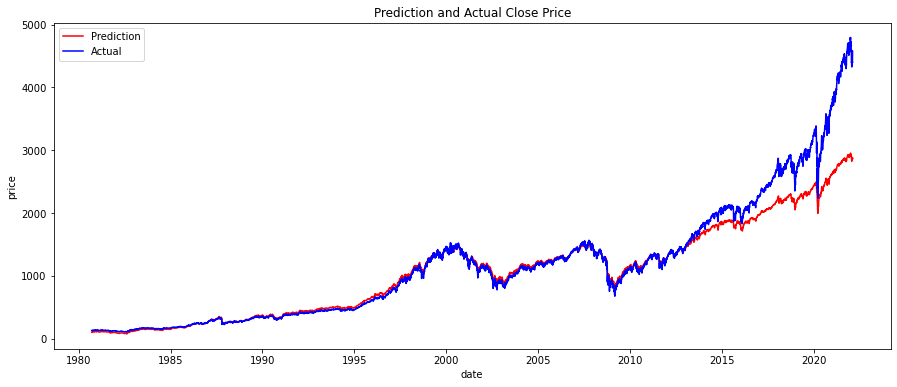

In [33]:
plt.figure(figsize=[15,6])
plt.plot(test_date_list[:, 0], prediction_val[:, 0], 'red', label = 'Prediction')
plt.plot(test_date_list[:, 0], actual[:, 0], 'blue', label = 'Actual')
plt.xlabel("date")

# date_ticks=np.arange(1996,2022,1)
# plt.xticks(date_ticks)

plt.ylabel("price")
plt.title("Prediction and Actual Close Price")
plt.legend()
plt

<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

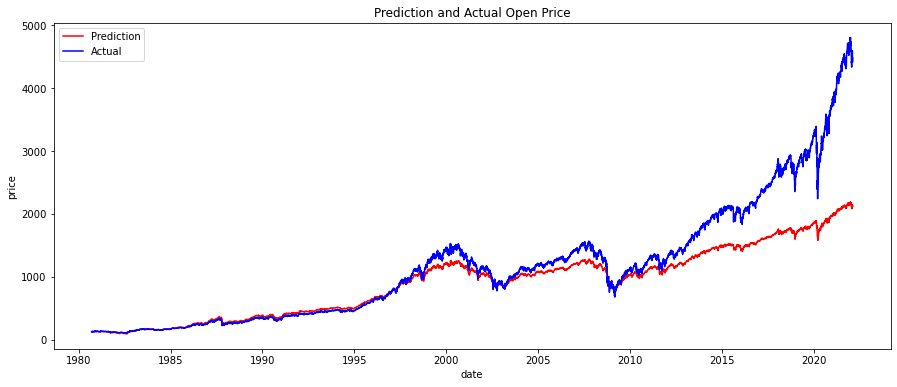

In [34]:
plt.figure(figsize=[15,6])
plt.plot(test_date_list[:, 0], prediction_val[:, 1], 'red', label = 'Prediction')
plt.plot(test_date_list[:, 0], actual[:, 1], 'blue', label = 'Actual')
plt.xlabel("date")

# date_ticks=np.arange(1996,2022,1)
# plt.xticks(date_ticks)

plt.ylabel("price")
plt.title("Prediction and Actual Open Price")
plt.legend()
plt

<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

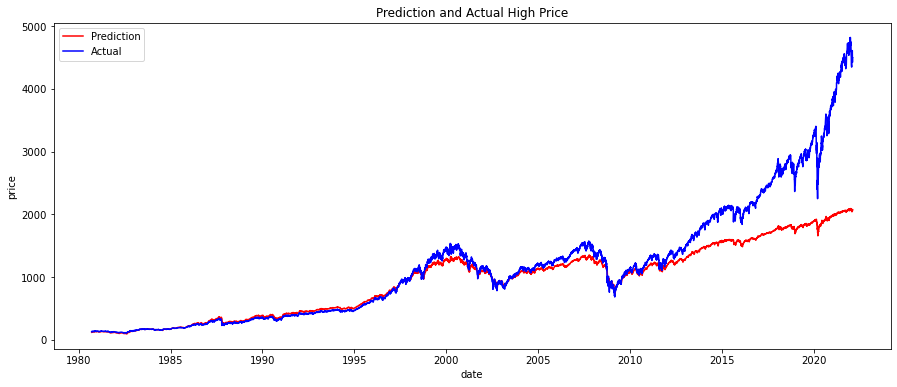

In [35]:
plt.figure(figsize=[15,6])
plt.plot(test_date_list[:, 0], prediction_val[:, 2], 'red', label = 'Prediction')
plt.plot(test_date_list[:, 0], actual[:, 2], 'blue', label = 'Actual')
plt.xlabel("date")

# date_ticks=np.arange(1996,2022,1)
# plt.xticks(date_ticks)

plt.ylabel("price")
plt.title("Prediction and Actual High Price")
plt.legend()
plt

<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

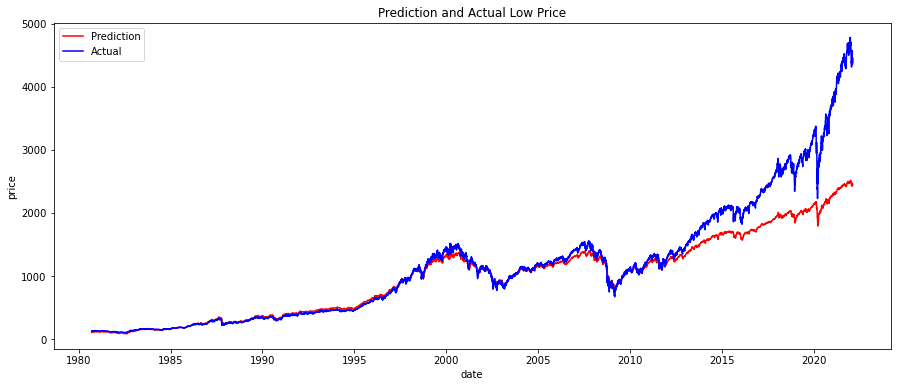

In [36]:
plt.figure(figsize=[15,6])
plt.plot(test_date_list[:, 0], prediction_val[:, 3], 'red', label = 'Prediction')
plt.plot(test_date_list[:, 0], actual[:, 3], 'blue', label = 'Actual')
plt.xlabel("date")

# date_ticks=np.arange(1996,2022,1)
# plt.xticks(date_ticks)

plt.ylabel("price")
plt.title("Prediction and Actual Low Price")
plt.legend()
plt

In [37]:
error_val = calculate_prediction_error(prediction_val, actual)
error_val

array([[0.21980549, 0.07502193, 0.09434879, 0.14625065],
       [0.20799281, 0.07578975, 0.09510218, 0.13177767],
       [0.20447368, 0.07370481, 0.07847222, 0.13102754],
       ...,
       [0.35984441, 0.51632852, 0.53583144, 0.44615219],
       [0.34757951, 0.51608363, 0.53886699, 0.4486652 ],
       [0.34903802, 0.5264487 , 0.53887012, 0.43949715]])

<module 'matplotlib.pyplot' from '/Users/hejianan/opt/anaconda3/envs/NN/lib/python3.7/site-packages/matplotlib/pyplot.py'>

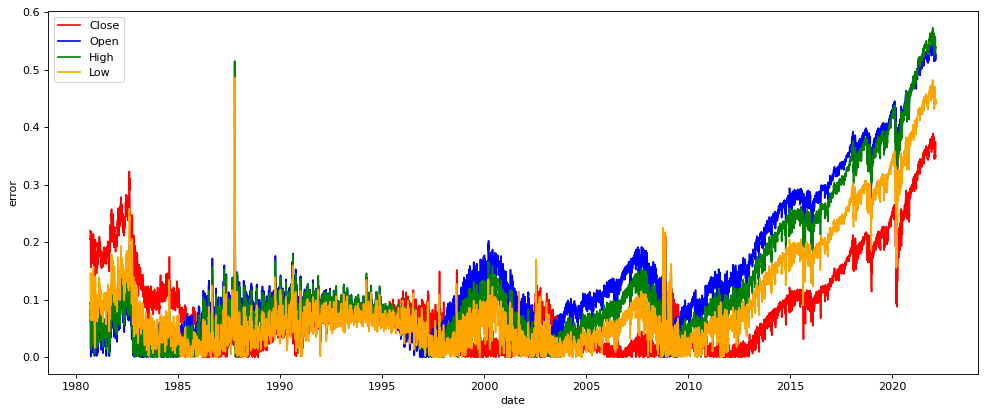

In [38]:
plt.figure(figsize=[15,6], dpi=80)
plt.plot(test_date_list[:, 0], error_val[:, 0], 'red', label = 'Close')
plt.plot(test_date_list[:, 0],error_val[:, 1], 'blue', label = 'Open')
plt.plot(test_date_list[:, 0],error_val[:, 2], 'green', label = 'High')
plt.plot(test_date_list[:, 0],error_val[:, 3], 'orange', label = 'Low')
plt.xlabel("date")
plt.ylabel("error")
plt.legend()
plt

In [39]:
def add_gaussian_noise(dataset, std_dev):
    dataset_reshape = dataset.reshape(dataset.shape[0] * dataset.shape[1] * dataset.shape[2], 1)
    noise = np.random.normal(0, std_dev, int(len(dataset_reshape) * 0.2))
    # Add the noise to image
    gp = np.random.uniform(0, dataset.shape[0] * dataset.shape[1] * dataset.shape[2], int(len(dataset_reshape) * 0.2))
    for i in range(int(len(dataset_reshape) * 0.2)):
        if dataset_reshape[int(gp[i])]==1:
            dataset_reshape[int(gp[i])]-=abs(noise[i])
        else:
            dataset_reshape[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    dataset_reshape = dataset_reshape.reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2])
    gaussian_out = np.clip(dataset_reshape, 0.00000001, 1)
    return gaussian_out

In [40]:
std_dev = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
gaussian_error_array = np.zeros([len(std_dev), test_real.shape[0], test_real.shape[2]])
for i in range(len(std_dev)):
    gaussian_real_test = add_gaussian_noise(test_real, std_dev[i])
    gaussian_label_test = add_gaussian_noise(test_label, std_dev[i])
#     gaussian_output = model(gaussian_real_test)
    gaussian_output, hidden = model_val(Variable(torch.from_numpy(gaussian_real_test).float()))
    gaussian_prediction = scaler.inverse_transform(gaussian_output.detach().numpy())
    gaussian_actual = np.concatenate( (gaussian_label_test[:, :, 0], gaussian_label_test[:, :, 1], gaussian_label_test[:, :, 2], gaussian_label_test[:, :, 3]), axis = 1)
    gaussian_actual = scaler.inverse_transform(gaussian_actual)
    gaussian_error = calculate_prediction_error(gaussian_prediction, gaussian_actual)
    gaussian_error_array[i] = gaussian_error
gaussian_error_array

array([[[0.20896899, 0.10226515, 0.08725488, 0.13616487],
        [0.19871817, 0.0662821 , 0.08558182, 0.12212705],
        [0.19223849, 0.07563966, 0.05871501, 0.11758898],
        ...,
        [0.3598359 , 0.51630243, 0.53619113, 0.44615044],
        [0.34829284, 0.51596424, 0.53879383, 0.44866224],
        [0.34896142, 0.5262434 , 0.53875217, 0.44003721]],

       [[0.20665223, 0.1006294 , 0.16361379, 0.13382237],
        [0.18985357, 0.06610149, 0.12750352, 0.11395524],
        [0.28736069, 0.12275847, 0.06603413, 0.11467427],
        ...,
        [0.35967735, 0.51809759, 0.53600925, 0.44613624],
        [0.34828964, 0.51599032, 0.54067404, 0.44865271],
        [0.35084118, 0.52630424, 0.53877405, 0.44002391]],

       [[0.14220352, 0.03262651, 0.10614934, 0.066074  ],
        [0.16941862, 0.04656873, 0.10642906, 0.09999009],
        [0.25117236, 0.07322638, 0.01319693, 0.07556167],
        ...,
        [0.35954368, 0.51811876, 0.53620702, 0.44595657],
        [0.34829074, 0.515991

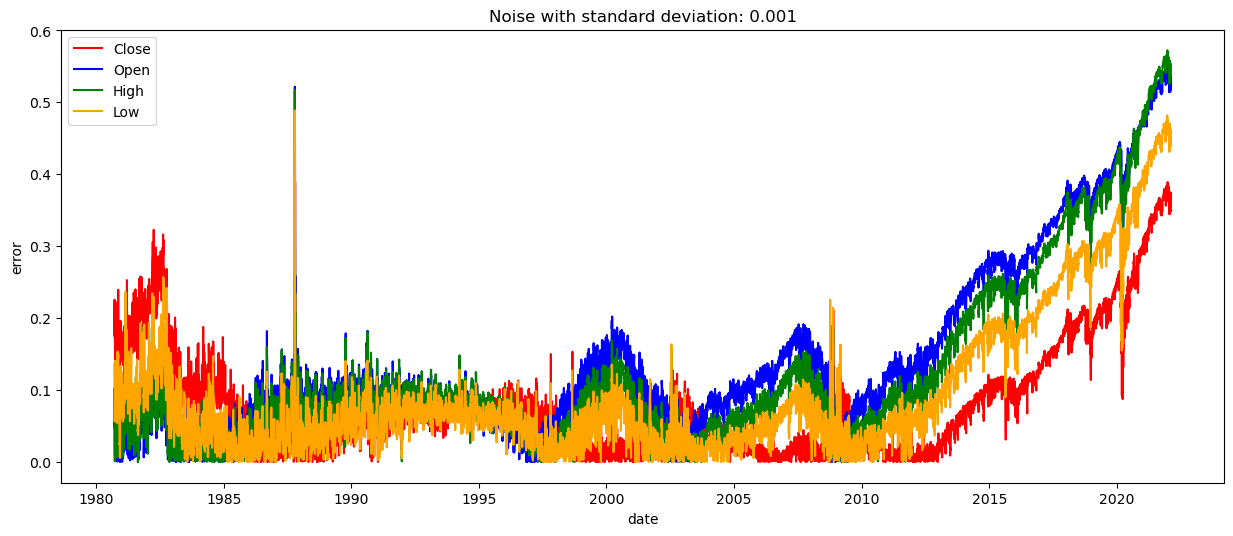

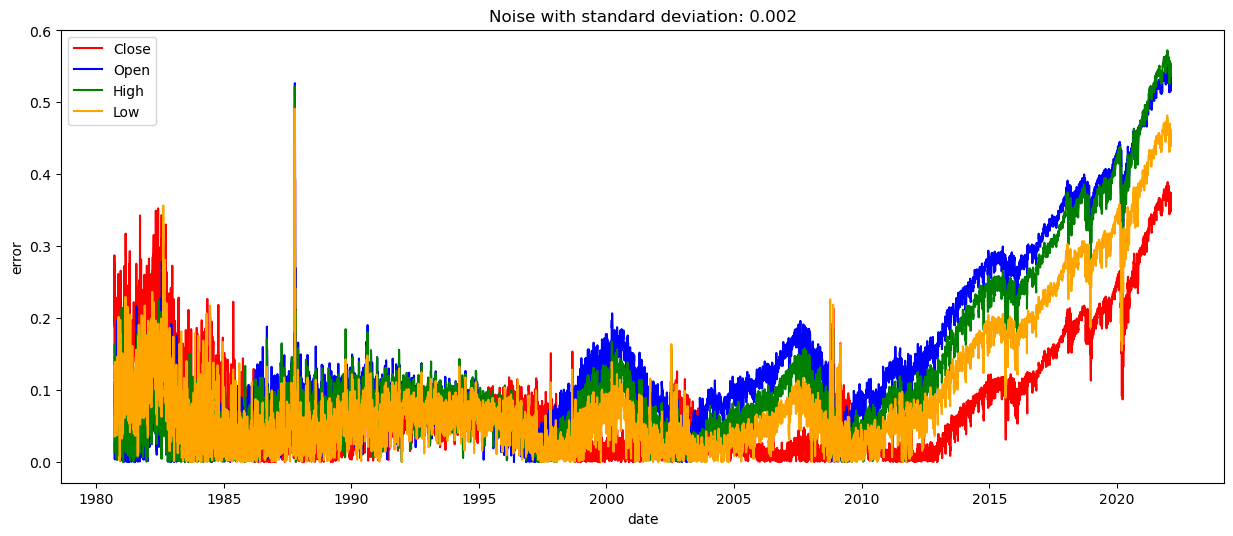

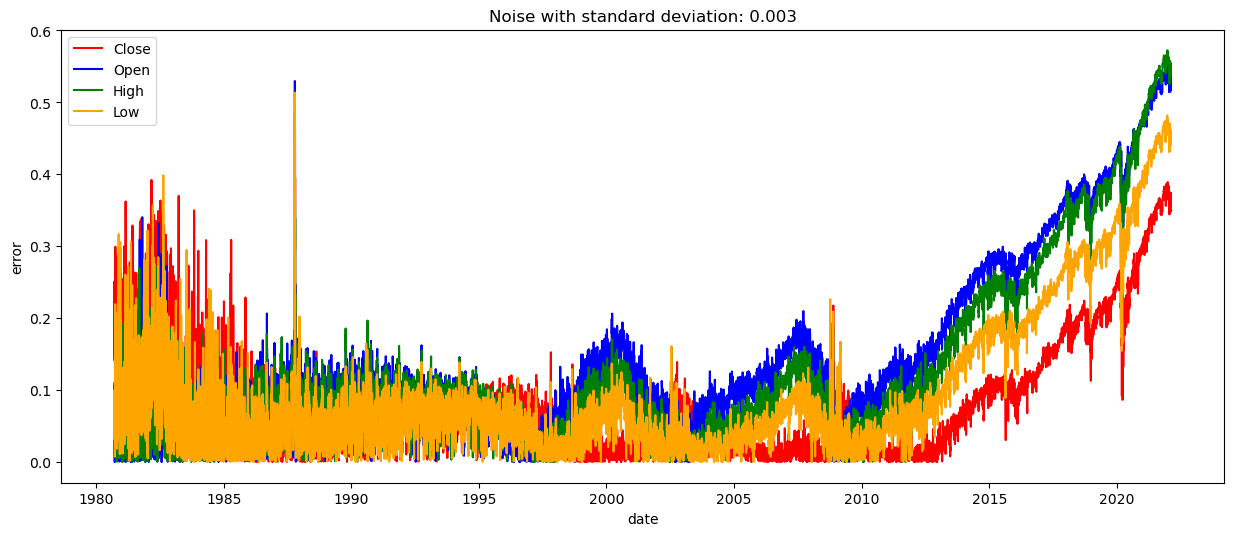

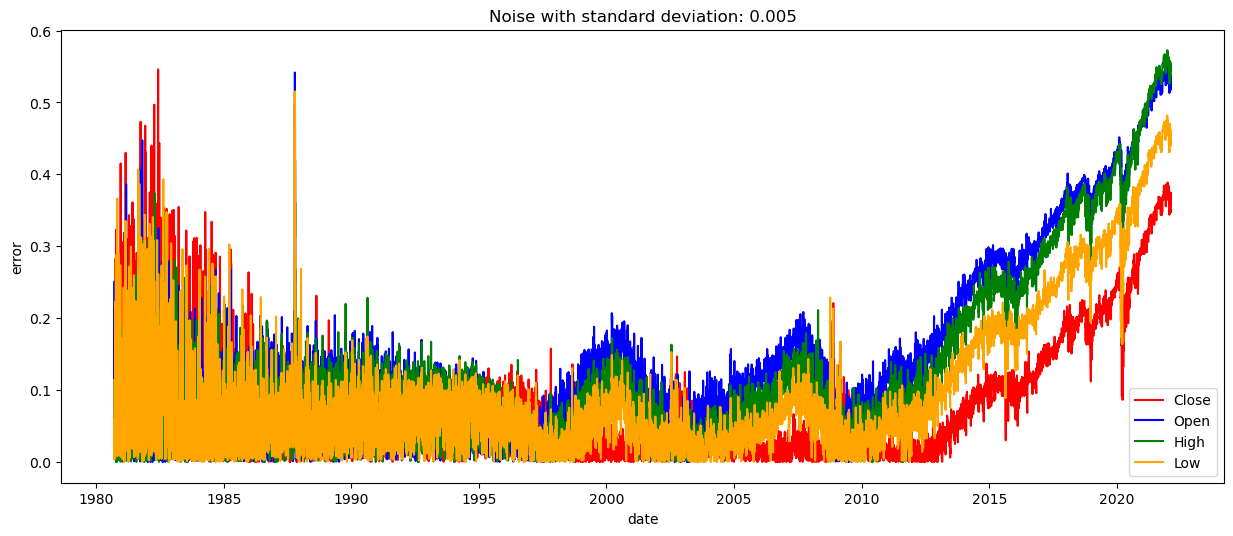

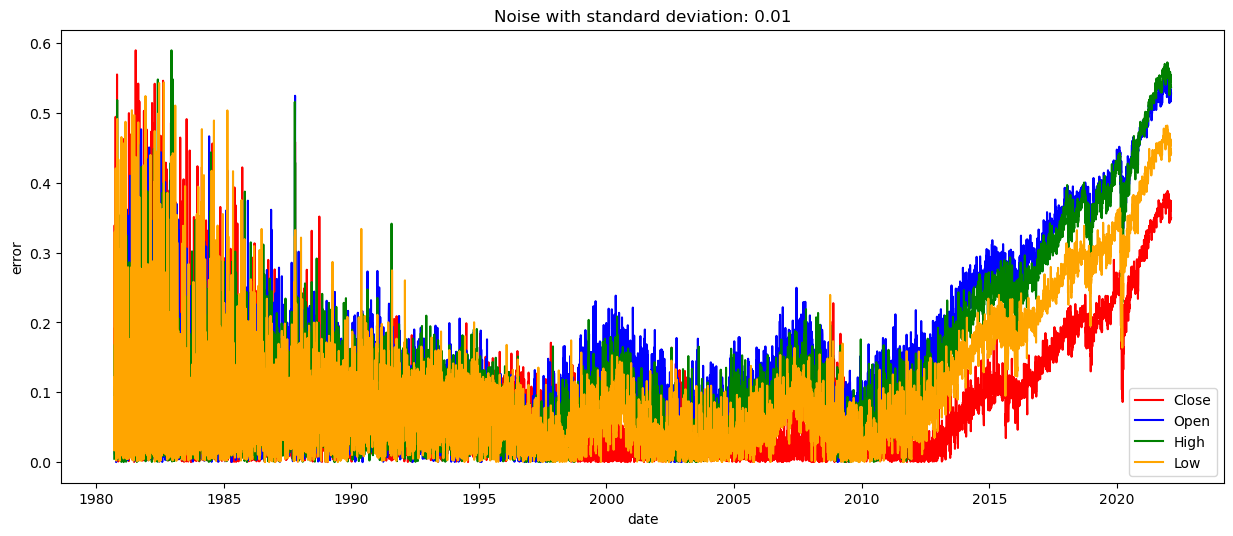

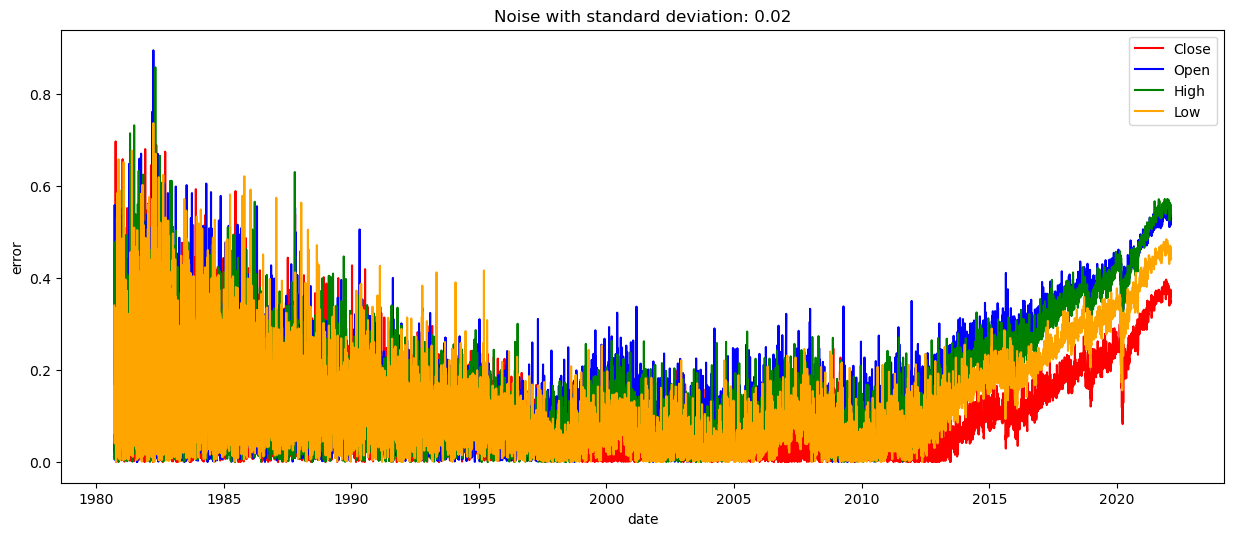

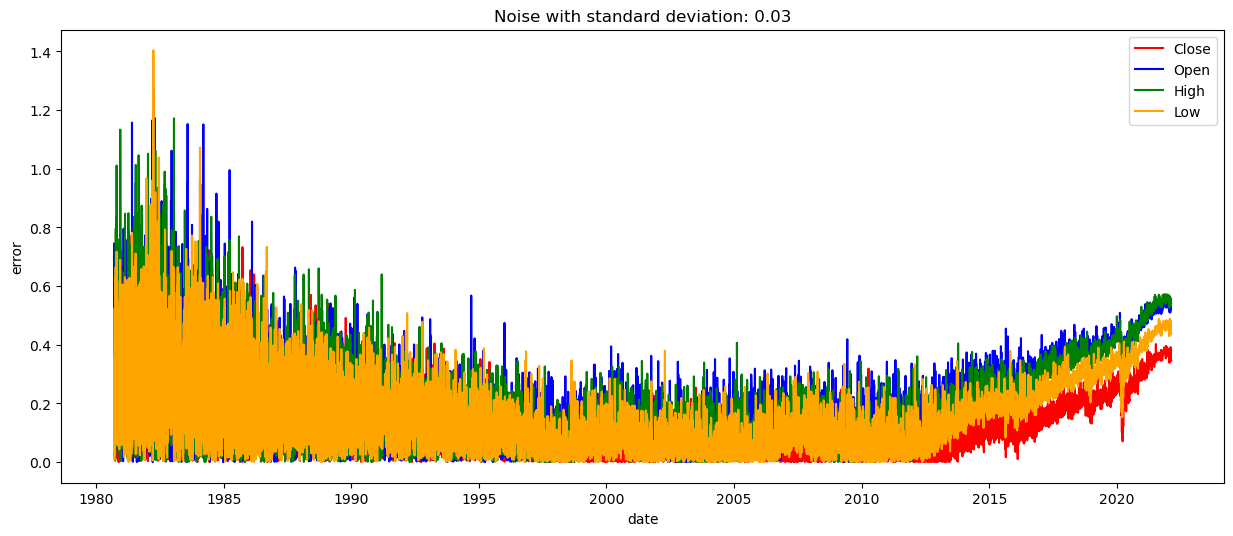

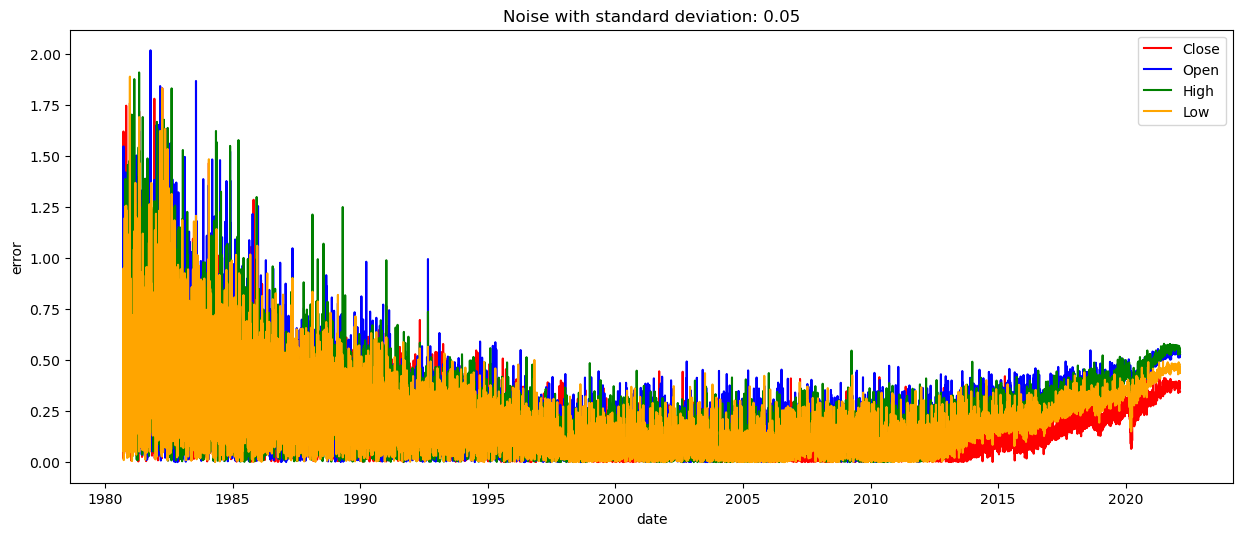

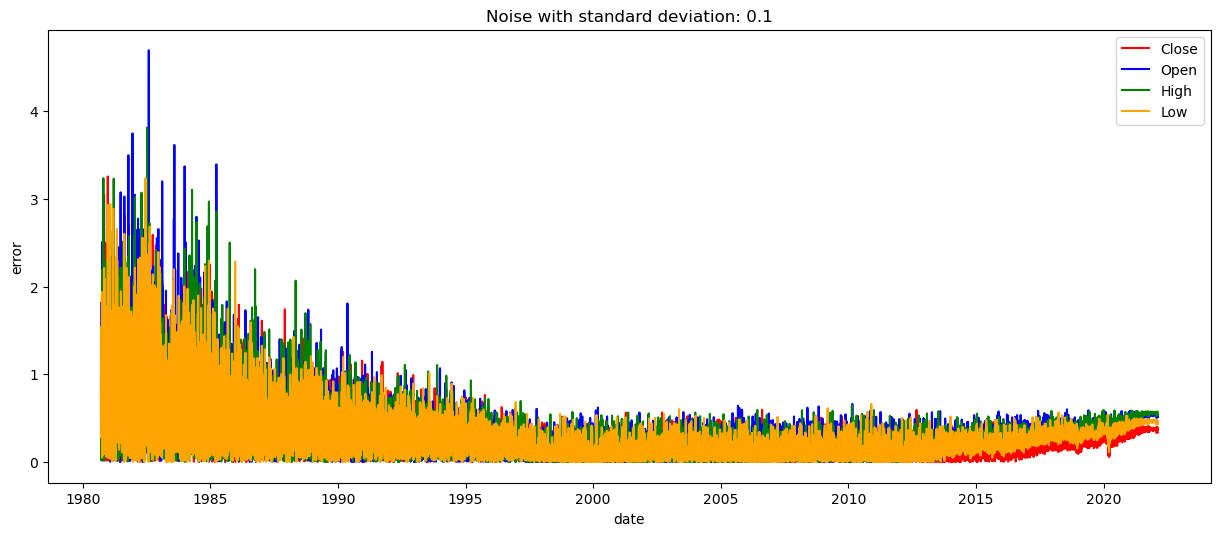

In [41]:
for i in range(len(std_dev)):
    plt.figure(figsize=[15,6], dpi=100)
    plt.plot(test_date_list[:, 0], gaussian_error_array[i, :, 0], 'red', label = 'Close')
    plt.plot(test_date_list[:, 0], gaussian_error_array[i, :, 1], 'blue', label = 'Open')
    plt.plot(test_date_list[:, 0], gaussian_error_array[i, :, 2], 'green', label = 'High')
    plt.plot(test_date_list[:, 0], gaussian_error_array[i, :, 3], 'orange', label = 'Low')
    plt.xlabel("date")
    plt.ylabel("error")
    plt.legend()
    plt.title("Noise with standard deviation: " + str(std_dev[i]))
    plt.show()